In [3]:
from STitch3D import *

In [4]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import scipy.io
import matplotlib.pyplot as plt
import os
import sys


import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# load datasets

## single-cell

In [6]:
mat = scipy.io.mmread("./data/snRNAseq_brain/GSE144136_GeneBarcodeMatrix_Annotated.mtx")
meta = pd.read_csv("./data/snRNAseq_brain/GSE144136_CellNames.csv.gz", index_col=0)
meta.index = meta.x.values
group = [i.split('.')[1].split('_')[0] for i in list(meta.x.values)]
condition = [i.split('.')[1].split('_')[1] for i in list(meta.x.values)]
celltype = [i.split('.')[0] for i in list(meta.x.values)]
meta["group"] = group
meta["condition"] = condition
meta["celltype"] = celltype
genename = pd.read_csv("./data/snRNAseq_brain/GSE144136_GeneNames.csv.gz", index_col=0)
genename.index = genename.x.values
adata_ref = ad.AnnData(X=mat.tocsr().T)
adata_ref.obs = meta
adata_ref.var = genename
adata_ref = adata_ref[adata_ref.obs.condition.values.astype(str)=="Control", :]

## spatial transcriptomics 

In [10]:
#spatial data
anno_df = pd.read_csv('./data/spatialLIBD/barcode_level_layer_map.tsv', sep='\t', header=None)

slice_idx = [151673, 151674, 151675, 151676]

adata_st1 = sc.read_visium(path="./data/spatialLIBD/%d" % slice_idx[0],
                          count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[0])
anno_df1 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[0])]
anno_df1.columns = ["barcode", "slice_id", "layer"]
anno_df1.index = anno_df1['barcode']
adata_st1.obs = adata_st1.obs.join(anno_df1, how="left")
adata_st1 = adata_st1[adata_st1.obs['layer'].notna()]

adata_st2 = sc.read_visium(path="./data/spatialLIBD/%d" % slice_idx[1],
                          count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[1])
anno_df2 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[1])]
anno_df2.columns = ["barcode", "slice_id", "layer"]
anno_df2.index = anno_df2['barcode']
adata_st2.obs = adata_st2.obs.join(anno_df2, how="left")
adata_st2 = adata_st2[adata_st2.obs['layer'].notna()]

adata_st3 = sc.read_visium(path="./data/spatialLIBD/%d" % slice_idx[2],
                          count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[2])
anno_df3 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[2])]
anno_df3.columns = ["barcode", "slice_id", "layer"]
anno_df3.index = anno_df3['barcode']
adata_st3.obs = adata_st3.obs.join(anno_df3, how="left")
adata_st3 = adata_st3[adata_st3.obs['layer'].notna()]

adata_st4 = sc.read_visium(path="./data/spatialLIBD/%d" % slice_idx[3],
                          count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[3])
anno_df4 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[3])]
anno_df4.columns = ["barcode", "slice_id", "layer"]
anno_df4.index = anno_df4['barcode']
adata_st4.obs = adata_st4.obs.join(anno_df4, how="left")
adata_st4 = adata_st4[adata_st4.obs['layer'].notna()]

## Alignment

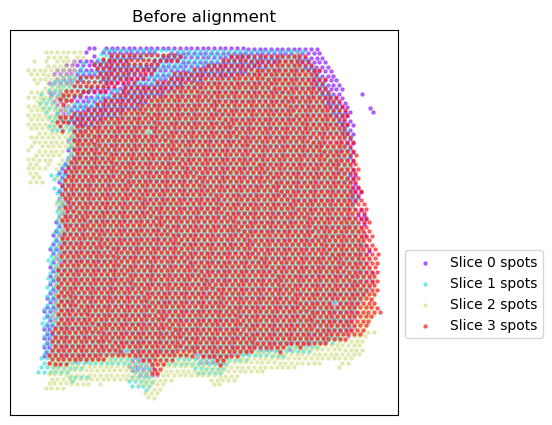

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


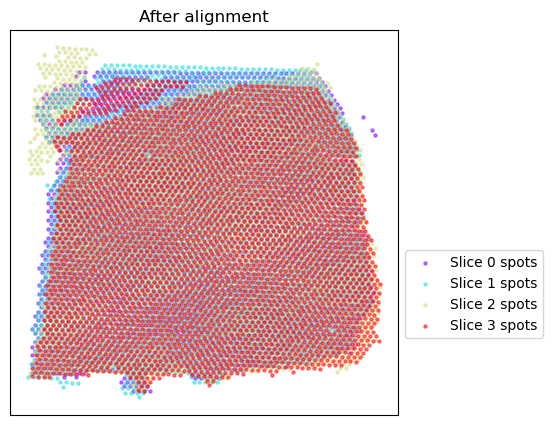

In [11]:
adata_st_list_raw = [adata_st1, adata_st2, adata_st3, adata_st4]
adata_st_list = STitch3D.utils.align_spots(adata_st_list_raw, plot=True)

In [12]:
celltype_list_use = ['Astros_1', 'Astros_2', 'Astros_3', 'Endo', 'Micro/Macro',
                     'Oligos_1', 'Oligos_2', 'Oligos_3',
                     'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5',
                     'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 'Ex_10_L2_4']

adata_st, adata_basis = STitch3D.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  celltype_ref=celltype_list_use,
                                                  sample_col="group",
                                                  slice_dist_micron=[10., 300., 10.],
                                                  n_hvg_group=500)

Finding highly variable genes...
4558 highly variable genes selected.
Calculate basis for deconvolution...
1 batches are used for computing the basis vector of cell type <Astros_1>.
17 batches are used for computing the basis vector of cell type <Astros_2>.
14 batches are used for computing the basis vector of cell type <Astros_3>.
17 batches are used for computing the basis vector of cell type <Endo>.
17 batches are used for computing the basis vector of cell type <Ex_10_L2_4>.
15 batches are used for computing the basis vector of cell type <Ex_1_L5_6>.
15 batches are used for computing the basis vector of cell type <Ex_2_L5>.
17 batches are used for computing the basis vector of cell type <Ex_3_L4_5>.
14 batches are used for computing the basis vector of cell type <Ex_4_L_6>.
17 batches are used for computing the basis vector of cell type <Ex_5_L5>.
16 batches are used for computing the basis vector of cell type <Ex_6_L4_6>.
16 batches are used for computing the basis vector of cell 

# Run Model

In [14]:
model = STitch3D.model.Model(adata_st, adata_basis, training_steps = 2000)

model.train(step_interval=200)

  0%|          | 1/2000 [00:04<2:23:16,  4.30s/it]

Step: 0, Loss: 2426.6580, d_loss: 2421.0381, f_loss: 56.1977


 10%|█         | 201/2000 [14:42<2:06:06,  4.21s/it]

Step: 200, Loss: 1251.7457, d_loss: 1248.4172, f_loss: 33.2850


 20%|██        | 401/2000 [29:27<2:03:05,  4.62s/it]

Step: 400, Loss: 1080.4015, d_loss: 1077.0872, f_loss: 33.1429


 30%|███       | 601/2000 [45:17<1:56:16,  4.99s/it]

Step: 600, Loss: 961.0354, d_loss: 957.7239, f_loss: 33.1149


 40%|████      | 801/2000 [1:01:22<1:31:31,  4.58s/it]

Step: 800, Loss: 879.8923, d_loss: 876.5829, f_loss: 33.0939


 50%|█████     | 1001/2000 [1:15:23<1:05:41,  3.95s/it]

Step: 1000, Loss: 828.0123, d_loss: 824.7054, f_loss: 33.0691


 60%|██████    | 1201/2000 [1:28:52<53:15,  4.00s/it]  

Step: 1200, Loss: 795.2022, d_loss: 791.8971, f_loss: 33.0512


 70%|███████   | 1401/2000 [1:42:27<44:08,  4.42s/it]

Step: 1400, Loss: 773.4857, d_loss: 770.1828, f_loss: 33.0289


 80%|████████  | 1601/2000 [1:56:26<26:37,  4.00s/it]

Step: 1600, Loss: 758.5643, d_loss: 755.2632, f_loss: 33.0105


 90%|█████████ | 1801/2000 [2:10:15<13:36,  4.10s/it]

Step: 1800, Loss: 747.5901, d_loss: 744.2909, f_loss: 32.9925


100%|██████████| 2000/2000 [2:23:55<00:00,  4.32s/it]


In [ ]:
save_path = "./results_DLPFC"
result = model.eval(adata_st_list_raw, save=True, output_path=save_path)